In [135]:
import numpy as np
import math
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import copy
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import time

In [136]:
class LinUCB():
    def __init__(self, arm, dim=2, lamda = 1, T=1000):
        self.arm = arm
        self.A_t = 0
        self.y = np.matrix(np.zeros((dim, 1)))
        self.V = np.matrix(lamda * np.identity(dim))
        self.lamda = lamda
        self.beta =  1 + np.sqrt(2*np.log(T)+dim*np.log((dim+T)/dim))
        self.actions = []
        self.T = T
        self.dim = dim
        self.action_idxs = []
        self.Vs = [copy.deepcopy(self.V)]
    def observe_reward(self, reward):
        
        self.V = self.V + self.arm[self.A_t].T * self.arm[self.A_t]
        self.Vs.append(copy.deepcopy(self.V))
        self.y = self.y + self.arm[self.A_t].T * reward
        
        
    def compute(self):
        inv_V = np.linalg.inv(self.V)
        self.hat_theta = inv_V * self.y
        ucb = self.arm * self.hat_theta + self.beta * np.matrix(np.diag(np.sqrt( self.arm * inv_V * self.arm.T ))).T
        self.A_t = np.argmax(ucb)
        self.actions.append(self.arm[self.A_t])
        self.action_idxs.append(self.A_t)
        return self.arm[self.A_t]

In [137]:
def Baseline1(alg):
    sample_means = np.random.rand(len(alg.sample_means))
    return sample_means

In [138]:
def Baseline2(alg):
    taus = [0] * alg.arm.shape[0]
    optimal_arm = alg.action_idxs[-1]
    num_pulls = {}
    for t, action in enumerate(alg.action_idxs):
        taus[action] = t

    for i in range(len(alg.arm)):
        num_pulls[i] = []

    for t in range(alg.T):
        for key in num_pulls.keys():
            if alg.action_idxs[t] != key:
                if t != 0:
                    num_pulls[key].append(num_pulls[key][ - 1])
                else:
                    num_pulls[key].append(0)
            else:
                if t != 0:
                    num_pulls[key].append(num_pulls[key][ - 1] + 1)
                else:
                    num_pulls[key].append(1)

    sample_means = []
    for idx, tau in enumerate(taus):
        if idx is not optimal_arm:
            sample_means.append(-2 * UCB.gcb(alg.T, alg.alpha, num_pulls[idx][tau]))
        else:
            sample_means.append(0)
    return np.asarray(sample_means)
    

In [139]:
class UCB:
    def __init__(self, action_set, dim=2, T=1000):
        self.arm = action_set
        self.T = T
        self.alpha = 1/(T**2)
        self.sample_means = np.asarray([0.0] * len(action_set))
        self.confidence_widths = np.asarray([np.inf] * len(action_set))
        self.num_pulls = np.asarray([0] * len(action_set))
        self.actions = []
        self.action_idxs = []
        self.dim = dim
        self.counter = 0
        self.debug_mean = {}
        self.debug_cw = {}
        self.debug_np = {}
        
    def compute(self):
        
        if self.counter < len(action_set):
            index = self.counter
        else:
            index = np.argmax(self.sample_means + self.confidence_widths)
        
        self.debug_mean[self.counter] = copy.deepcopy(self.sample_means)
        self.debug_cw[self.counter] = copy.deepcopy(self.confidence_widths)
        self.debug_np[self.counter] = copy.deepcopy(self.num_pulls)
        self.counter += 1
        self.num_pulls[index] += 1
        
        self.action_idxs.append(index)
        self.actions.append(self.arm[index])
        return self.arm[index]
    
    def observe_reward(self, reward):
        
        cur_mean = self.sample_means[self.action_idxs[-1]]
        num_samples = self.num_pulls[self.action_idxs[-1]] - 1
        new_mean = (cur_mean * num_samples + reward)/(num_samples + 1)
        self.sample_means[self.action_idxs[-1]] = new_mean
        self.confidence_widths[self.action_idxs[-1]] = self.gcb(self.T, self.alpha, num_samples + 1)
        
    @staticmethod
    def gcb(T, alpha, num_samples):
        return np.sqrt(2*(math.pow(T, alpha) - 1)/(alpha * num_samples))
        
        
         

In [140]:
def calc_pseudoregret(theta, actions):
    diff = theta - np.max(theta)
    new_actions = np.stack(actions, axis=0)
    return -np.sum(np.dot(new_actions, theta))

In [141]:
class Oracle:
    def __init__(self, theta, upper=1, lower=0):
        self.theta = theta
        self.upper = upper
        self.lower = lower
        
    def compute_reward(self, action):
        mu = np.inner(action, self.theta)
        sigma = .2
        X = truncnorm((self.lower - mu) / sigma, (self.upper - mu) / sigma, loc=mu, scale=sigma)
        return X.rvs(1)[0]


In [142]:
def train_alg(alg, T, theta, oracle):
    alg.actions = [0]
    reward = oracle.compute_reward(alg.arm[0])
    alg.observe_reward(reward)
    for time in range(T):
        action = alg.compute()
        reward = oracle.compute_reward(action)
        alg.observe_reward(reward)
        
def train_alg_UCB(alg, T, theta, oracle):
    for time in range(T):
        action = alg.compute()
        reward = oracle.compute_reward(action)
        alg.observe_reward(reward)

In [143]:
def generate_k_dim_vector(dim=2):
    full_index = random.randint(0,dim-1)
    vec = np.random.random(int(dim)) * 2 - 1
    vec[full_index] = np.sign(vec[full_index]) * 1
    return vec

def generate_random_vec(dim=2, mag=1):
    vec = np.random.random(int(dim))
    vec = vec/np.linalg.norm(vec)*mag
    return vec

In [144]:
def plot_vectors(theta, actions):
    plt.axis([-1, 1, -1, 1])
    plt.quiver(0, 0, theta[0], theta[1], color='green', scale=1)
    for idx, action in enumerate(actions):
        plt.quiver(0, 0, action[0], action[1], color = [(idx/len(actions), 0, 0)], scale=1)

In [145]:
#Change action set to boundaries
#Check how two thetas with same optimal actions will have different action sequences
#Why are these different? How will these differ?
#Choose different colors and figure out the scale
#check about frequency of "pulls", sum the action sequence!
#Candidate values of theta: alternating signs (like with 0.9, 0.5 as values, a lot of coordinates should differ), alternating signs with only one coord differs
#Exploratory: If you were just solving mab, can you formulat an alternative estimator that is a solution to an lp
#Exploratory: decision variables are unknown means where you have to solve, and every time an arm is pulled, you get a constraint
# You also get other constraints that when an arm is not pulled, you get an equality constraint
#so look at the end of the horizon, and get the lp from there

In [146]:
import gurobipy as gp

def estimate_ucb_means_lp(alg):
    m = gp.Model()
    m.Params.LogToConsole = 0
    all_vars = {}
    num_pulls = {}
    T = alg.T
    for i in range(len(action_set)):
        num_pulls[i] = []

    for t in range(T):
        for key in num_pulls.keys():
            if alg.action_idxs[t] != key:
                if t != 0:
                    num_pulls[key].append(num_pulls[key][ - 1])
                else:
                    num_pulls[key].append(0)
            else:
                if t != 0:
                    num_pulls[key].append(num_pulls[key][ - 1] + 1)
                else:
                    num_pulls[key].append(1)

    for t in range(T):
        for idx, ele in enumerate(action_set):
            if t not in all_vars:
                all_vars[t] = {}
            all_vars[t][idx] = m.addVar(name="u_{}_{}".format(t, idx))

    expr = gp.LinExpr()
    list_of_all_vars = []
    for t in range(T-1,T):
        for i in range(len(action_set)):
            list_of_all_vars.append(all_vars[t][i])


    expr.addTerms([1.0] * len(list_of_all_vars), list_of_all_vars)

#     m.setObjective(expr, gp.GRB.MAXIMIZE)



    for t, ele in enumerate(alg.action_idxs):
        for i in range(len(action_set)):
            if i != ele and t >= len(action_set):
                m.addConstr(all_vars[t][ele] + UCB.gcb(T, alg.alpha, num_pulls[ele][t-1]) - all_vars[t][i] - UCB.gcb(T, alg.alpha, num_pulls[i][t - 1]) >= 0)
                if t + 1 < T:
                    m.addConstr(all_vars[t + 1][i] - all_vars[t][i] == 0)
            m.addConstr(all_vars[t][i] >= 0)
            m.addConstr(all_vars[t][i] <= 1)



    m.optimize()
    lp_vals = []
    for i in range(len(action_set)):
        lp_vals.append(all_vars[T-1][i].X)
        
    return lp_vals

In [148]:
def calc_Vs(alg):
    Vs = []
    Vs.append(alg.lamda * np.identity(alg.dim))
    for t in range(T):
        Vs.append(Vs[-1] + (alg.actions[t].T * alg.actions[t]))
    return(Vs)

def get_orthogonal_matrix(vec):
    first = np.identity(len(vec) - 1)
    second = -1 * vec[1:] / vec[0]

    others = np.concatenate((second, first),axis=0)

    banana = others @ (others.T @ others) @ others.T

    return banana

def estimate_linucb_means_lp(alg, normalize=True, tolerance=1e-5):
    m = gp.Model()
    m.Params.LogToConsole = 0
    all_vars = {}
    T = alg.T

    Vs = calc_Vs(alg)
    for t in range(alg.T):
        all_vars[t] = []
        for i in range(alg.dim):
            all_vars[t].append(m.addVar(name="y_{}_{}".format(t, i)))

    expr = gp.LinExpr()
    expr.addTerms([1.0] * len(all_vars[alg.T - 1]),all_vars[alg.T - 1])

#     m.setObjective(expr, gp.GRB.MAXIMIZE) 
    for t in range(T):
        for action in action_set:
            V = Vs[t]
            invV = np.linalg.inv(V)
            if action is not alg.actions[t]:
                expr = gp.LinExpr()

                mult = np.asarray(action @ invV)[0] * -1
                expr.addTerms(mult, all_vars[t])
                constant = np.sqrt(action @ invV @ action.T) * alg.beta * -1
                expr.addConstant(constant)

                opt_mult = np.asarray(alg.actions[t] @ invV)[0]
                expr.addTerms(opt_mult, all_vars[t])
                opt_constant = np.sqrt(alg.actions[t] @ invV @ alg.actions[t].T) * alg.beta
                expr.addConstant(opt_constant)

                m.addConstr(expr >= 0)

                
    for t in range(T):
        if t == T - 1:
            continue
        a_t = alg.actions[t]
        V_t = Vs[t]
        V_tplus1 = Vs[t+1]
        
        V_t_inv = np.linalg.pinv(V_t)
        V_tplus1_inv = np.linalg.pinv(V_tplus1)
        
        orthogonal_projection = get_orthogonal_matrix(V_t_inv @ a_t.T)
        first_coeff = np.asarray(orthogonal_projection @ V_tplus1_inv)
        second_coeff = np.asarray(orthogonal_projection @ V_t_inv)
        
        for curr_dim in range(first_coeff.shape[0]):
            firstexpr = gp.LinExpr()
            firstexpr.addTerms(first_coeff[curr_dim], all_vars[t+1])
            firstexpr.addTerms(-1 * second_coeff[curr_dim], all_vars[t])
            m.addConstr(firstexpr >= -1 * tolerance)
            m.addConstr(firstexpr <= tolerance)
            
        
    for i in range(alg.dim):
        m.addConstr(all_vars[0][i] == 0)



    for i in range(alg.dim):
        for t in range(alg.T):
            if t + 1 < alg.T:
                m.addConstr(all_vars[t][i] + 1 >= all_vars[t + 1][i])
                m.addConstr(all_vars[t][i] <= all_vars[t+1][i])

    m.optimize()

    final_Vinv = np.linalg.inv(Vs[-1])
    final_y = np.matrix([ele.X for ele in all_vars[alg.T - 1]]).T
    
    
    theta_estimate = np.linalg.inv(Vs[-1]) @ np.matrix(final_y)
    
    if normalize:
        theta_estimate = theta_estimate/np.linalg.norm(theta_estimate)
        
    return theta_estimate

In [149]:
def normalize_subopt(means):
    means = np.asarray(means)
    best_value = max(means)
    return best_value - means

def test_Baseline1(theta, action_set, T=1000):
    dim = theta.shape[-1]
    oracle = Oracle(theta)
    alg = UCB(action_set, T=T, dim=dim)
    train_alg_UCB(alg, T, theta, oracle)
    
    t1 = time.time()
    estimate_sample_means = normalize_subopt(Baseline1(alg))
    t2 = time.time()
    
    return mean_squared_error(normalize_subopt(alg.sample_means), estimate_sample_means), t2 - t1
    
def test_Baseline2(theta, action_set, T=1000):
    dim = theta.shape[-1]
    oracle = Oracle(theta)
    alg = UCB(action_set, T=T, dim=dim)
    train_alg_UCB(alg, T, theta, oracle)
    
    t1 = time.time()
    estimate_sample_means = normalize_subopt(Baseline2(alg))
    t2 = time.time()
    return mean_squared_error(normalize_subopt(alg.sample_means), estimate_sample_means), t2 - t1

In [150]:
def test_UCB(theta, action_set, T=1000):
    dim = theta.shape[-1]
    oracle = Oracle(theta)
    alg = UCB(action_set, T=T, dim=dim)
    train_alg_UCB(alg, T, theta, oracle)
    
    t1 = time.time()
    lp_vals = normalize_subopt(estimate_ucb_means_lp(alg))
    t2 = time.time()
    return mean_squared_error(normalize_subopt(alg.sample_means), lp_vals), t2 - t1
    
def test_LinUCB(theta, action_set, T=1000):
    
    oracle = Oracle(theta)
    dim = theta.shape[-1]
    alg = LinUCB(action_set, dim=dim, T=T)
    
    train_alg_UCB(alg, T, theta, oracle)
    t1 = time.time()
    true_means = normalize_subopt(action_set @ alg.hat_theta)
    theta_estimate = estimate_linucb_means_lp(alg)
    estimate_means = normalize_subopt(action_set @ theta_estimate)
    t2 = time.time()
    return mean_squared_error(true_means, estimate_means), t2 - t1

In [151]:
Ts =  [128, 256, 512, 1024, 2048]
NumArmss = [2, 8, 16, 32, 64, 128]
num_epochs = 10

ucb_errors = {}
linucb_errors = {}
baseline_1_errors = {}
baseline_2_errors = {}

ucb_times = {}
linucb_times = {}
baseline_1_times = {}
baseline_2_times = {}

num_skipped = 0
for T in Ts:
    
    ucb_errors[T] = {}
    linucb_errors[T] = {}
    baseline_1_errors[T] = {}
    baseline_2_errors[T] = {}
    
    ucb_times[T] = {}
    linucb_times[T] = {}
    baseline_1_times[T] = {}
    baseline_2_times[T] = {}
    
    for num_arms in NumArmss:      
        ucb_errors[T][num_arms] = []
        linucb_errors[T][num_arms] = []
        baseline_1_errors[T][num_arms] = []
        baseline_2_errors[T][num_arms] = []
        
        ucb_times[T][num_arms] = []
        linucb_times[T][num_arms] = []
        baseline_1_times[T][num_arms] = []
        baseline_2_times[T][num_arms] = []
        
        for _ in tqdm(range(num_epochs)):
            theta = np.matrix(generate_random_vec(dim = 2))
            action_set = np.matrix([generate_random_vec(dim = 2) for _ in range(num_arms)])
            ucb_error, ucb_time = test_UCB(theta, action_set, T=T)
            lin_ucb_error, lin_ucb_time = test_LinUCB(theta, action_set, T=T)
            baseline_1_error, baseline_1_time = test_Baseline1(theta, action_set, T=T)
            baseline_2_error, baseline_2_time = test_Baseline2(theta, action_set, T=T)

            linucb_errors[T][num_arms].append(lin_ucb_error)
            ucb_errors[T][num_arms].append(ucb_error)
            baseline_1_errors[T][num_arms].append(baseline_1_error)
            baseline_2_errors[T][num_arms].append(baseline_2_error)

            linucb_times[T][num_arms].append(lin_ucb_time)
            ucb_times[T][num_arms].append(ucb_time)
            baseline_1_times[T][num_arms].append(baseline_1_time)
            baseline_2_times[T][num_arms].append(baseline_2_time)
            num_skipped += 1
                
print(num_skipped)

 20%|████████▊                                   | 2/10 [00:09<00:37,  4.72s/it]


AttributeError: Unable to retrieve attribute 'X'

In [75]:
print(linucb_errors)
print(ucb_errors)
print(baseline_1_errors)
print(baseline_2_errors)

{128: {2: [0.039774867426792704, 0.09487165401500451, 0.19992558249914688, 0.11238459202479337, 0.03810207602315202, 0.005722497441980266, 5.55871198976912e-06, 0.09076948012723882, 0.16565493838898926, 0.1783997074649699]}}
{128: {2: [0.000931206789203055, 0.5000209343764254, 0.4223607819668142, 4.4374681931641715e-06, 5.657911481767827e-06, 5.323162765365823e-07, 4.8830976370942406e-06, 0.5046010018665128, 0.4925431762637247, 0.00022504695866367084]}}
{128: {2: [0.0014696547344065078, 0.23180383914545236, 0.0305494078731551, 0.0020287260921762595, 0.38419434509622746, 0.030245310269437185, 0.04101670457364962, 0.025617665195903406, 0.010149813136890423, 0.05959888397709982]}}
{128: {2: [0.00046313017009875975, 2.0579028397689505e-06, 0.0016508534834907748, 0.004569627736197566, 0.0006786619241572185, 3.44342303390267e-05, 0.00030962897997972264, 0.0009420117394453151, 0.0007291849588563819, 2.1299651648996053e-05]}}


In [76]:
import pickle

with open("data_not_original.pkl", "wb") as f:
    pickle.dump((ucb_errors, linucb_errors, baseline_1_errors, baseline_2_errors), f)

In [77]:
with open("data.pkl", "rb") as f:
    ucb_errors, linucb_errors, baseline_1_errors, baseline_2_errors = pickle.load(f)

In [115]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
import pickle
Ts =  [128, 256, 512, 1024, 2048]
NumArmss = [2, 8, 16, 32, 64, 128]
def plot(errors, title, remove_outliers=False):
    plt.clf()
    data = []
    for T in Ts:
        for num_arms in NumArmss:
            for ele in errors[T][num_arms]:
                if not remove_outliers or ele < 20:
                    data.append((T, num_arms, ele))
                    
    x, y, z = zip(*data)
    print("Mean Error: {}".format(np.mean(z)))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    ax.scatter(x,y,z)
    ax.set_xlabel("T")
    ax.set_ylabel("Num Arms")
    ax.set_zlabel("MSE")
    plt.savefig("linucb.png")
    plt.show()

def plot_many(errors_list, names, title, remove_outliers=False):
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', "tab:red"]
    for idx, errors in enumerate(errors_list):
    
        data = []
        for T in Ts:
            for num_arms in NumArmss:
                for ele in errors[T][num_arms]:
                    if not remove_outliers or ele < 20:
                        data.append((T, num_arms, ele))

        x, y, z = zip(*data)
        ax.scatter(x,y,z, c=colors[idx], label=names[idx])
    ax.legend()
    ax.set_xlabel("T")
    ax.set_ylabel("Num Arms")
    ax.set_zlabel("MSE")
    plt.savefig("linucb.png")
    plt.show()

Mean Error: 0.5412183790326163


<Figure size 432x288 with 0 Axes>

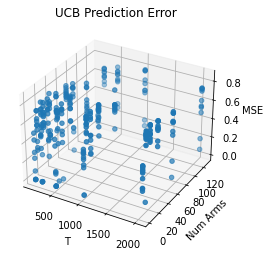

In [113]:
plot(ucb_errors, "UCB Prediction Error")

Mean Error: 0.007697888259073261


<Figure size 432x288 with 0 Axes>

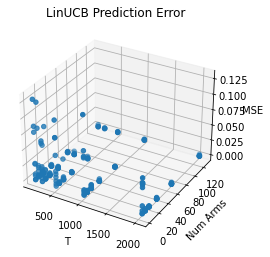

In [114]:
plot(linucb_errors, "LinUCB Prediction Error")

<Figure size 432x288 with 0 Axes>

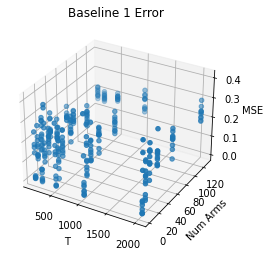

In [81]:
plot(baseline_1_errors, "Baseline 1 Error")

<Figure size 432x288 with 0 Axes>

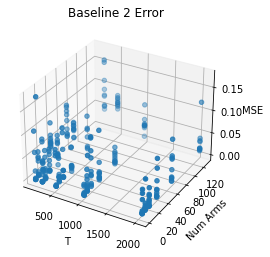

In [82]:
plot(baseline_2_errors, "Baseline 2 Error", remove_outliers=True)

<Figure size 432x288 with 0 Axes>

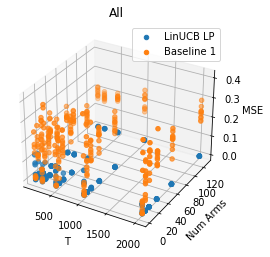

In [86]:
plot_many([linucb_errors, baseline_1_errors], ["LinUCB LP", "Baseline 1"], "All", remove_outliers=True)

<Figure size 432x288 with 0 Axes>

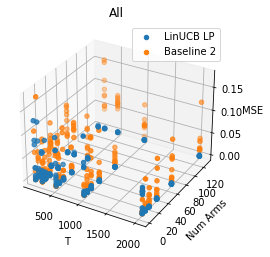

In [87]:
plot_many([linucb_errors, baseline_2_errors], ["LinUCB LP", "Baseline 2"], "All", remove_outliers=True)

In [14]:
print(baseline_1_errors)

{128: {2: [0.11811419647315978, 0.006471613285499168, 0.032244446268327405, 0.04992393406598355, 0.0032489711463628518, 0.00045385225745159447, 9.879509384609865e-05, 0.004783803547495503, 0.003685803507197123, 0.06892979186045092]}}


In [107]:
print(lin_ucb_errors)

NameError: name 'lin_ucb_errors' is not defined